In [1]:
# Import required libraries and dependencies
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Load the data into a Pandas DataFrame and make the index the "coin_id" column.
market_data_df = pd.read_csv("Resources/crypto_market_data.csv", index_col="coin_id")

# Display sample data
market_data_df.head()


,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384


In [3]:
# Generate summary statistics
market_data_df.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.269686,4.497147,0.185787,1.545693,-0.094119,236.537432,347.667956
std,2.694793,6.375218,8.376939,26.344218,47.365803,435.225304,1247.842884
min,-13.527860,-6.094560,-18.158900,-34.705480,-44.822480,-0.392100,-17.567530
25%,-0.608970,0.047260,-5.026620,-10.438470,-25.907990,21.660420,0.406170
50%,-0.063410,3.296410,0.109740,-0.042370,-7.544550,83.905200,69.691950
75%,0.612090,7.602780,5.510740,4.578130,0.657260,216.177610,168.372510
max,4.840330,20.694590,24.239190,140.795700,223.064370,2227.927820,7852.089700


### Prepare the Data

In [4]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
scaler = StandardScaler()

scaled_data = scaler.fit_transform(market_data_df)

In [5]:
# Create a DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=market_data_df.columns, index=market_data_df.index)

# Copy the crypto names from the original data
crypto_names = ['bitcoin', 'ethereum', 'tether', 'ripple', 'bitcoin-cash', 'binancecoin', 'chainlink', 'cardano', 'litecoin', 'bitcoin-cash-sV']

# Set the coinid column as index
scaled_df.index.name = 'coin_id'

# Display sample data
display(scaled_df.head())

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317


### Find the Best Value for k Using the Original Scaled DataFrame.

In [6]:
# Create a list with the number of k-values to try
# Use a range from 1 to 11
k_values = list(range(1, 12))

# Create an empty list to store the inertia values
inertia_values = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using the scaled DataFrame
# 3. Append the model.inertia_ to the inertia list
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    
    kmeans.fit(scaled_df)
    
    inertia_values.append(kmeans.inertia_)


# Create a dictionary with the data to plot the Elbow curve
elbow_data = {
    'k': k_values,
    'inertia': inertia_values
}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df = pd.DataFrame(elbow_data)

# Display the DataFrame
display(elbow_df)

,k,inertia
0,1,287.000000
1,2,195.820218
2,3,123.190482
3,4,79.022435
4,5,64.968027
5,6,53.548593
6,7,43.128508
7,8,36.850091
8,9,32.678899
9,10,28.438827


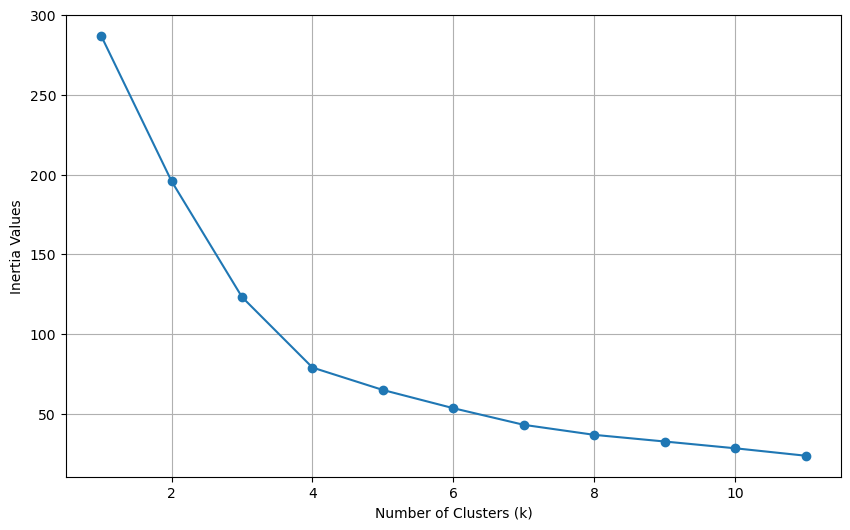

In [7]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
plt.figure(figsize=(10, 6))
plt.plot(elbow_data['k'], elbow_data['inertia'], marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Values')
plt.grid(True)
plt.show()


#### Answer the following question: 
**Question:** What is the best value for `k`?

**Answer:** The best value for `k` is 4

### Cluster Cryptocurrencies with K-means Using the Original Scaled Data.

In [8]:
# Initialize the K-Means model using the best value for k
best_k = 4
kmeans = KMeans(n_clusters=best_k, n_init=10)


In [9]:
# Fit the K-Means model using the scaled data
kmeans.fit(scaled_df)

KMeans(n_clusters=4, n_init=10)

In [10]:
# Predict the clusters to group the cryptocurrencies using the scaled data
clusters = kmeans.predict(scaled_data)

# View the resulting array of cluster values.
clusters

/Users/jamiemcgraner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 3, 1, 1, 1, 1],
      dtype=int32)

In [11]:
# Create a copy of the DataFrame
clustered_data = market_data_df.copy()

In [12]:
# Add a new column to the DataFrame with the predicted clusters
clustered_data['Cluster'] = clusters

# Display sample data
clustered_data

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,Cluster
coin_id,,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761,0
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023,0
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954,1
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193,1
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384,0
binancecoin,2.10423,12.85511,6.80688,0.05865,36.33486,155.61937,69.69195,0
chainlink,-0.23935,20.69459,9.30098,-11.21747,-43.69522,403.22917,325.13186,0
cardano,0.00322,13.99302,5.55476,10.10553,-22.84776,264.51418,156.09756,0
litecoin,-0.06341,6.60221,7.28931,1.21662,-17.23960,27.49919,-12.66408,0


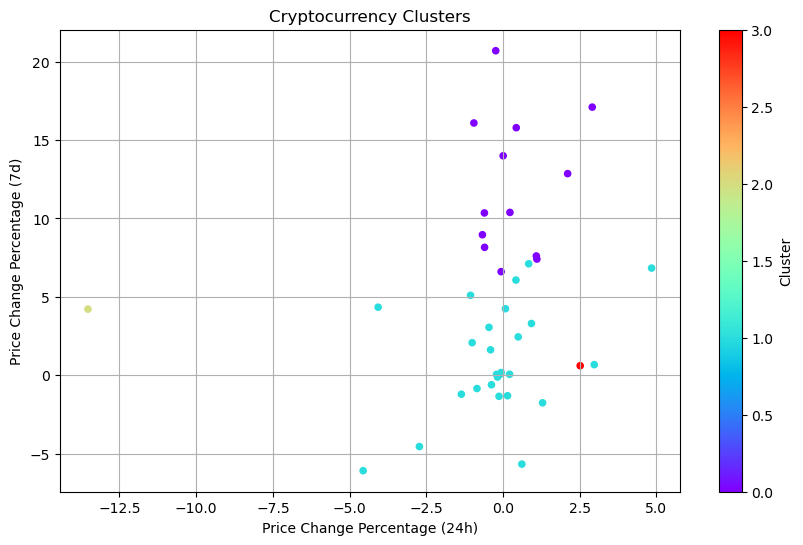

In [13]:
# Create a scatter plot using Pandas plot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`.
# Use "rainbow" for the color to better visualize the data.
clustered_data.plot(
    kind='scatter',
    x='price_change_percentage_24h',
    y='price_change_percentage_7d',
    c='Cluster',
    colormap='rainbow',
    figsize=(10,6))
plt.xlabel('Price Change Percentage (24h)')
plt.ylabel('Price Change Percentage (7d)')
plt.title('Cryptocurrency Clusters')
plt.grid(True)
plt.show()

### Optimize Clusters with Principal Component Analysis.

In [14]:
# Create a PCA model instance and set `n_components=3`.
pca_model = PCA(n_components=3)

In [15]:
# Use the PCA model with `fit_transform` on the original scaled DataFrame to reduce to three principal components.


# View the first five rows of the DataFrame. 


In [16]:
# Retrieve the explained variance to determine how much information  can be attributed to each principal component.


#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** 

In [17]:
# Create a new DataFrame with the PCA data.
# Note: The code for this step is provided for you

# Creating a DataFrame with the PCA data


# Copy the crypto names from the original data


# Set the coinid column as index


# Display sample data


### Find the Best Value for k Using the PCA Data

In [18]:
# Create a list with the number of k-values to try
# Use a range from 1 to 11


# Create an empty list to store the inertia values


# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using PCA DataFrame.
# 3. Append the model.inertia_ to the inertia list


# Create a dictionary with the data to plot the Elbow curve


# Create a DataFrame with the data to plot the Elbow curve


# Display the DataFrame


In [19]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.


#### Answer the following questions: 
* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:** 


* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** 

### Cluster Cryptocurrencies with K-means Using the PCA Data

In [20]:
# Initialize the K-Means model using the best value for k


In [21]:
# Fit the K-Means model using the PCA data


In [22]:
# Predict the clusters to group the cryptocurrencies using the PCA data


# Print the resulting array of cluster values.


In [23]:
# Create a copy of the DataFrame with the PCA data


# Add a new column to the DataFrame with the predicted clusters


# Display sample data


In [24]:
# Create a scatter plot using hvPlot by setting `x="PCA1"` and `y="PCA2"`. 


### Determine the Weights of Each Feature on each Principal Component

In [25]:
# Use the columns from the original scaled DataFrame as the index.


#### Answer the following question: 

* **Question:** Which features have the strongest positive or negative influence on each component? 
 
* **Answer:** 
    